## Васильев Семён. 520 группа

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.stattools as st

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def autocorr(ts, lags=15):
    fig, ax = plt.subplots(figsize=(14, 7))
    sm.graphics.tsa.plot_acf(ts, lags=lags, ax=ax, adjusted=True, alpha=0.05)
    plt.show()

In [3]:
def autopartcorr(ts, lags=15):
    fig, ax = plt.subplots(figsize=(14, 7))
    sm.graphics.tsa.plot_pacf(ts, lags=lags, ax=ax, alpha=0.05)
    plt.show()

In [4]:
data = pd.read_excel('PET_PRI_GND_DCUS_NUS_W.xls', sheet_name='Data 1')
data = data.iloc[2:,0:2]
data.columns = ['date', 'gasoline']
data.index = data.date
data = data['gasoline']
data = data.loc['2017-03-11':]
data = pd.DataFrame(data)
data

,gasoline
date,
2017-03-13,2.434
2017-03-20,2.433
2017-03-27,2.428
2017-04-03,2.471
2017-04-10,2.534
...,...
2022-01-31,3.464
2022-02-07,3.538
2022-02-14,3.581


Проверка на стационарность и идентификация модели.

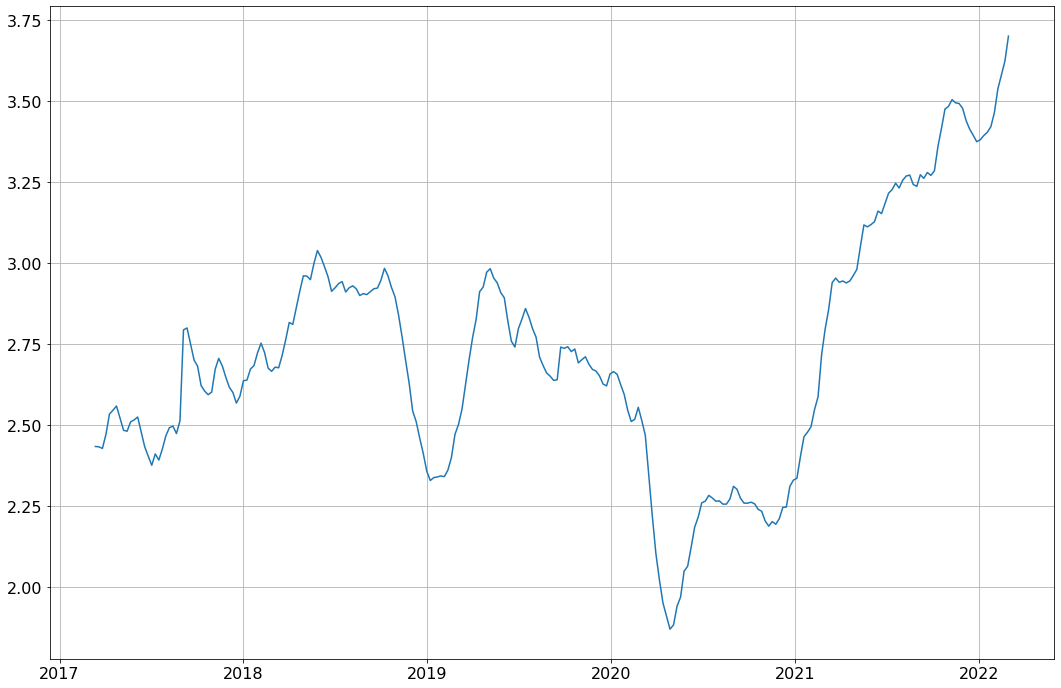

In [5]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(18, 12))
plt.grid()

plt.plot(data)

In [6]:
st.adfuller(data)[1]

0.8603477229423394

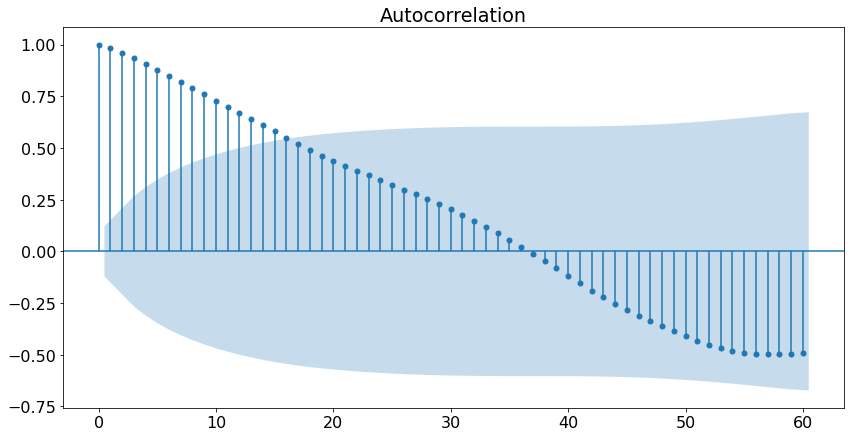

In [7]:
autocorr(data, lags=60)

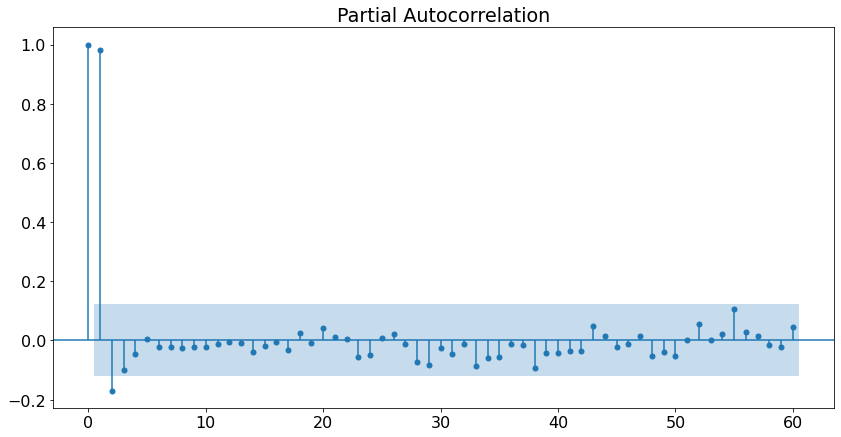

In [8]:
autopartcorr(data, lags=60)

In [9]:
diffs = data.diff()[1:]
diffs

,gasoline
date,
2017-03-20,-0.001
2017-03-27,-0.005
2017-04-03,0.043
2017-04-10,0.063
2017-04-17,0.012
...,...
2022-01-31,0.043
2022-02-07,0.074
2022-02-14,0.043


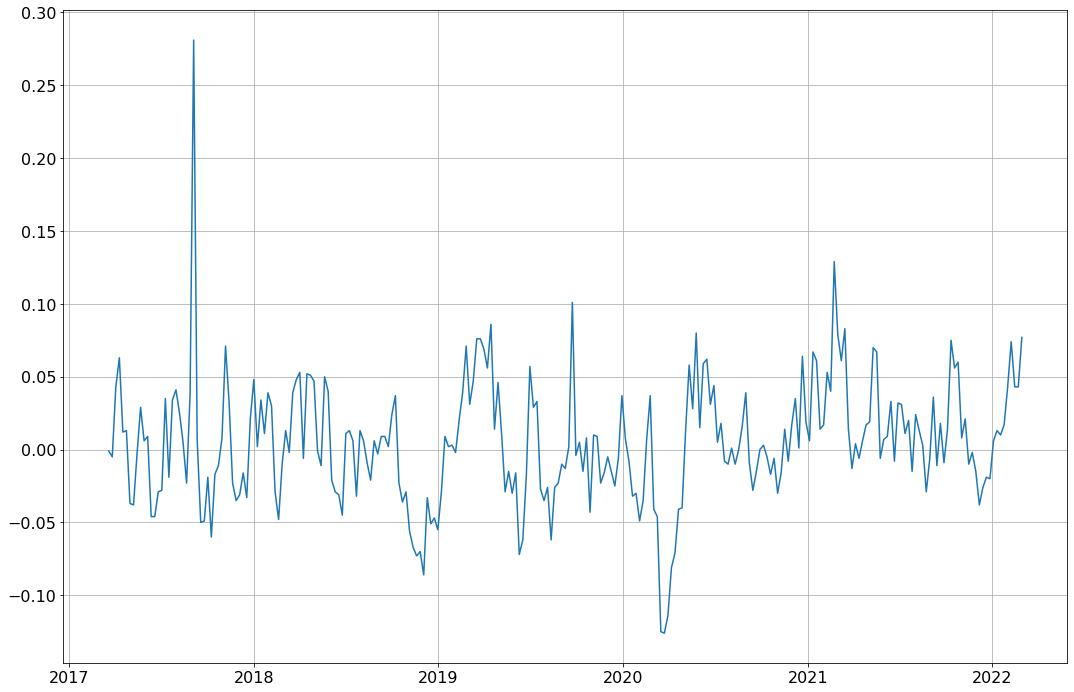

In [10]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(18, 12))
plt.grid()

plt.plot(diffs)

In [11]:
st.adfuller(diffs)[1]

2.5597444748201416e-13

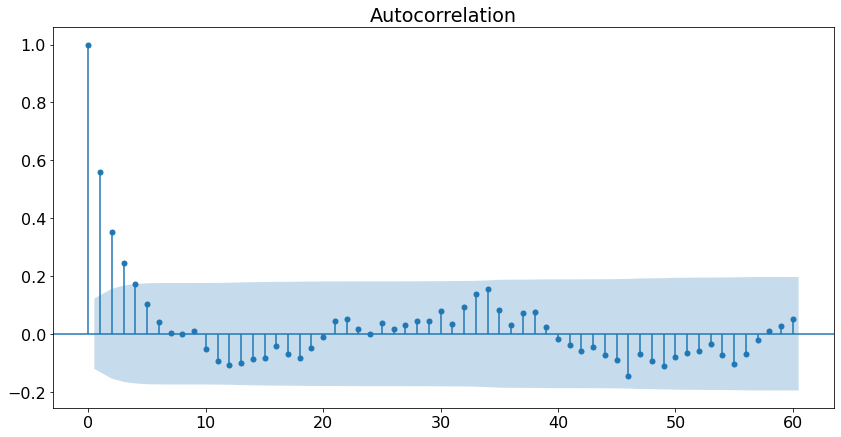

In [12]:
autocorr(diffs, lags=60)

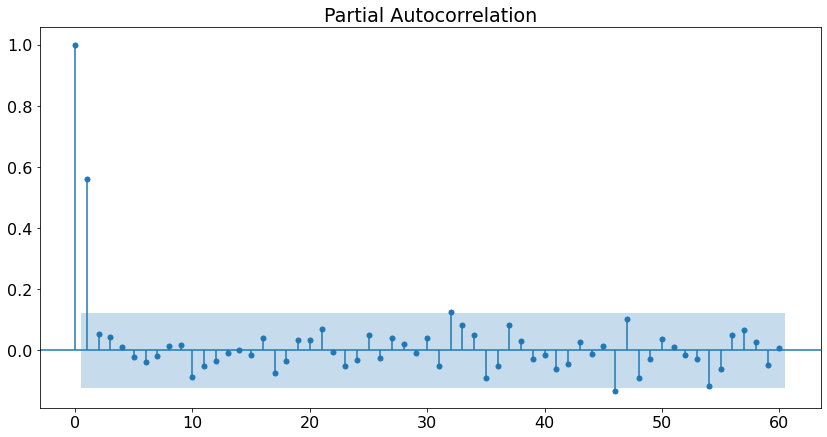

In [13]:
autopartcorr(diffs, lags=60)

Исходный ряд нестационарен по тесту Дики-Фуллера. Ряд разностей стационарен.

В прошлом тесте по AIC была подобрана модель AR(1).

In [ ]:
ar1 = sm.tsa.ARMA(diffs.values, order=(1, 0)).fit(method='MLE')
ar1.summary()

In [15]:
from statsmodels.stats.diagnostic import het_arch
'''Engle’s Test for Autoregressive Conditional Heteroscedasticity (ARCH).'''

'Engle’s Test for Autoregressive Conditional Heteroscedasticity (ARCH).'

In [16]:
print(f'Engle’s Test p-value: {het_arch(ar1.resid, nlags=52, ddof=1)[1]}')

Engle’s Test p-value: 0.9985972962325282


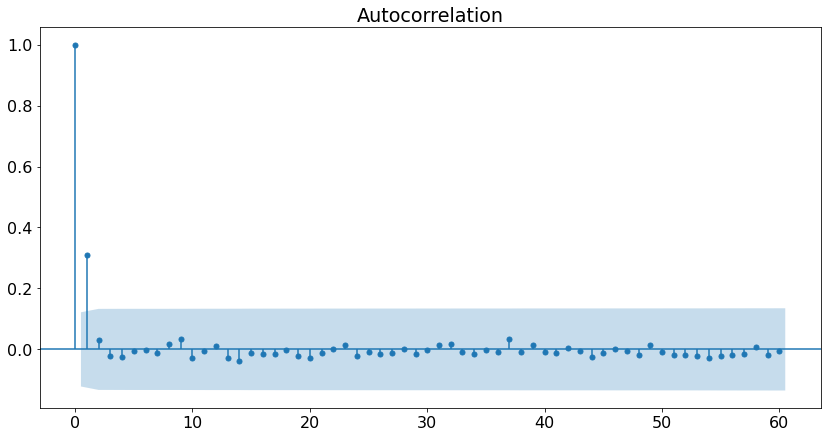

In [17]:
autocorr(ar1.resid**2, lags=60)

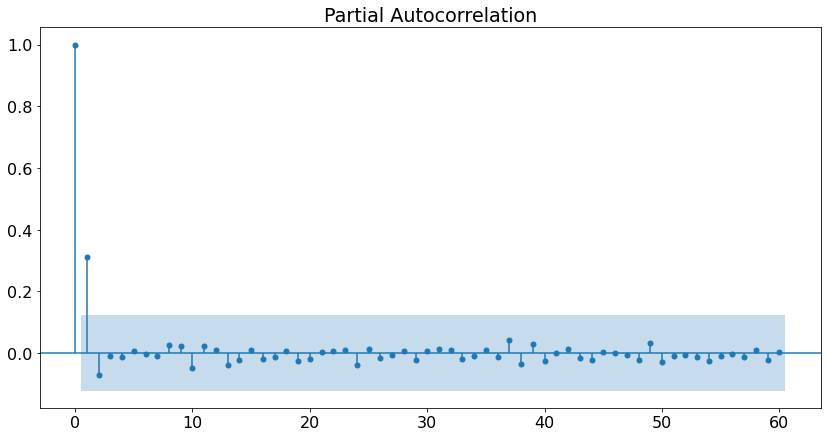

In [18]:
autopartcorr(ar1.resid**2, lags=60)

In [19]:
from arch import arch_model

In [ ]:
aics = []
for q in range(3):
    for p in range(1, 3):
        model = arch_model(ar1.resid, mean='Zero', vol='GARCH', p=p, q=q)
        res = model.fit(show_warning=False)
        aics.append(res.aic)

In [21]:
i = 0
for q in range(3):
    for p in range(1, 3):
        print(f'AIC GARCH({q}, {p}): {aics[i]}')
        i += 1

AIC GARCH(0, 1): -1017.8664383913527
AIC GARCH(0, 2): -1015.8664384043886
AIC GARCH(1, 1): -1015.8664383996257
AIC GARCH(1, 2): -1013.8664384017701
AIC GARCH(2, 1): -1013.8664383952837
AIC GARCH(2, 2): -1011.8664383769683


In [ ]:
ar1 = sm.tsa.ARMA(diffs.values[:-12], order=(1, 0)).fit(method='MLE')
ar1_forecast = ar1.forecast(12)
garch = arch_model(ar1.resid, mean='Zero', vol='GARCH', p=1, q=0).fit()
garch_forecast = garch.forecast(horizon=12)

In [23]:
mean = ar1_forecast[0]
var = garch_forecast.variance.iloc[-1].values
confs = []
for i in range(len(mean)):
    confs.append(stats.norm(loc=mean[i], scale=var[i]**0.5).ppf([0.025, 0.975]))
confs = np.array(confs).T

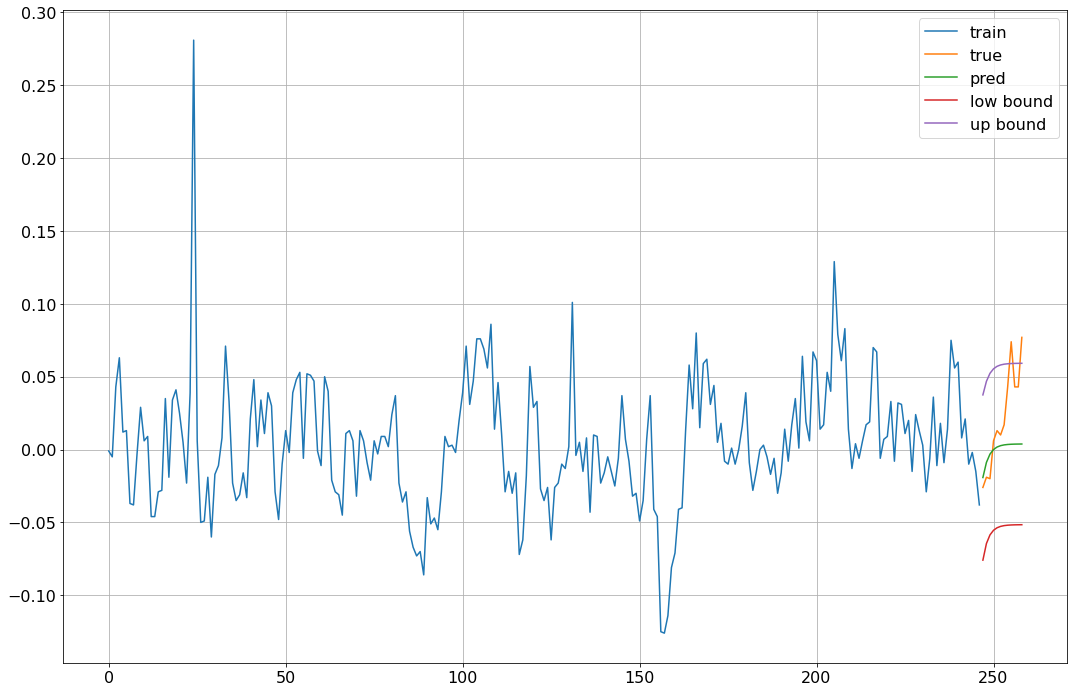

In [24]:
font = {'size': 16}
plt.rc('font', **font)
fig, ax = plt.subplots(figsize=(18, 12))
plt.grid()

plt.plot(list(range(len(diffs) - 12)), diffs.values[:-12], label='train')
plt.plot(list(range(len(diffs) - 12, len(diffs))), diffs.values[-12:], label='true')
plt.plot(list(range(len(diffs) - 12, len(diffs))), mean, label='pred')
plt.plot(list(range(len(diffs) - 12, len(diffs))), confs[0], label='low bound')
plt.plot(list(range(len(diffs) - 12, len(diffs))), confs[1], label='up bound')

plt.legend()

In [25]:
variant_data = pd.read_csv('variant.csv').drop(['Unnamed: 0'], axis=1)
variant_data

,V1
0,-3.482303
1,-5.631105
2,-6.232270
3,-2.036858
4,2.047844
...,...
495,-51.726363
496,-3.525286
497,-8.635950
498,12.210656


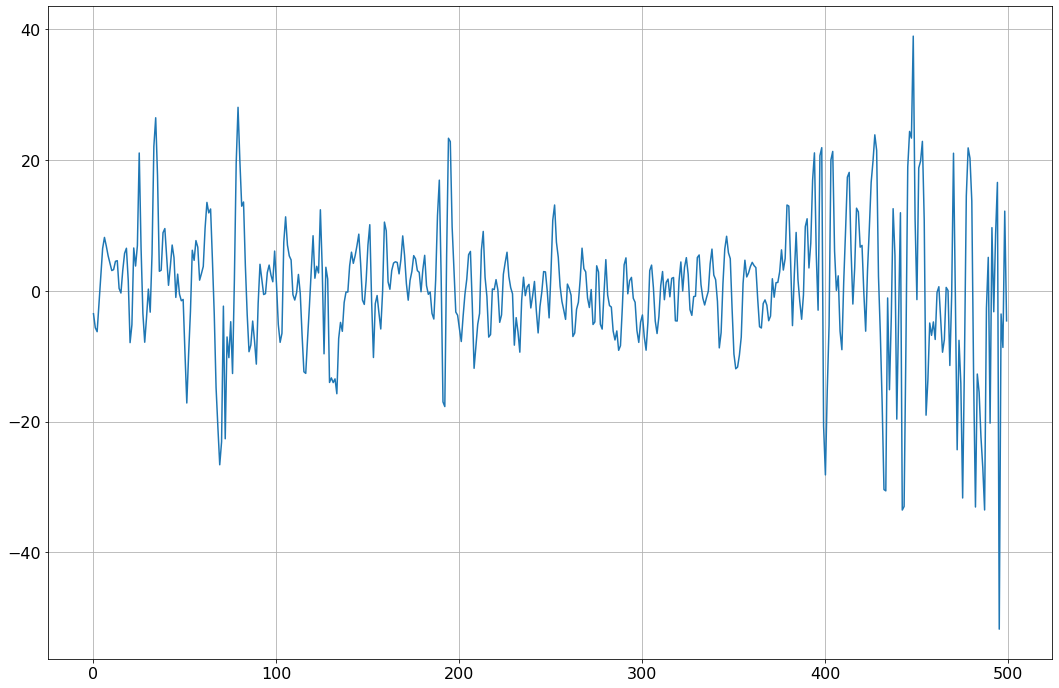

In [26]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(18, 12))
plt.grid()

plt.plot(variant_data)

In [27]:
st.adfuller(variant_data)[1]

2.8516474211986685e-07

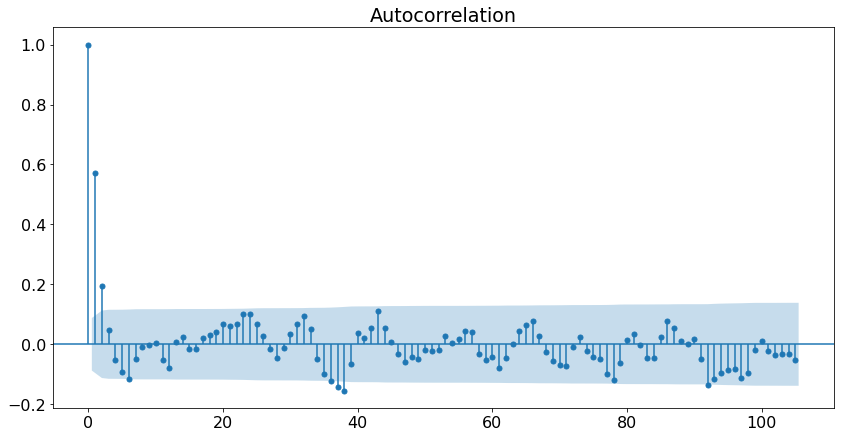

In [28]:
autocorr(variant_data, lags=105)

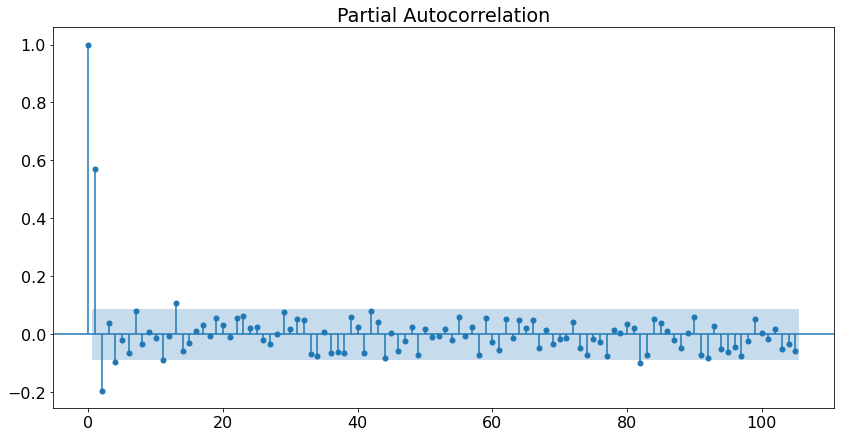

In [29]:
autopartcorr(variant_data, lags=105)

In [30]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
arima = ARIMA(
    variant_data, order=(4, 0, 6), 
    seasonal_order=(0, 0, 1, 38)
).fit()

In [32]:
arima.aic

3492.48899149873

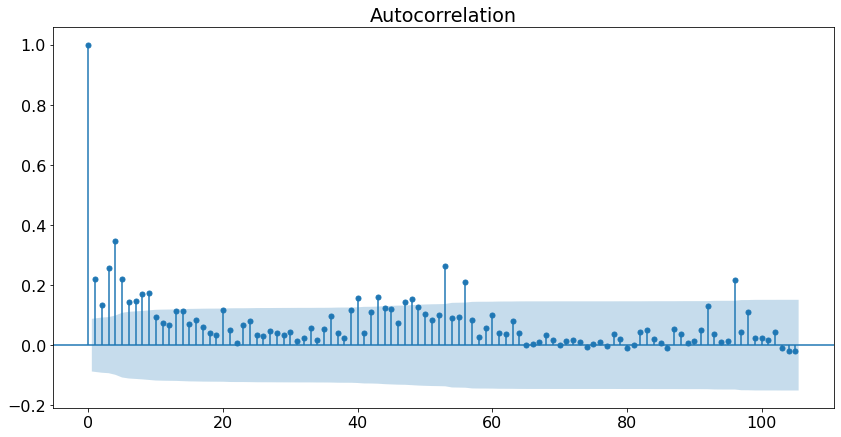

In [33]:
autocorr(arima.resid**2, lags=105)

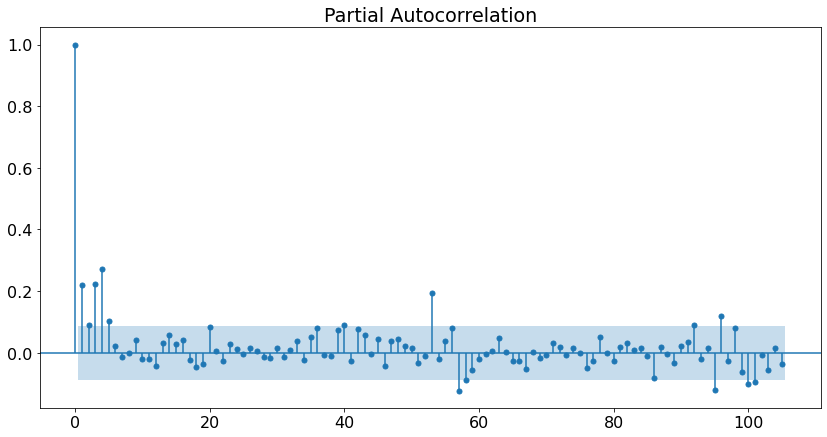

In [34]:
autopartcorr(arima.resid**2, lags=105)

In [ ]:
model = arch_model(arima.resid, mean='Zero', vol='GARCH', p=5, q=9)
res = model.fit(show_warning=False)

In [36]:
res.aic

3175.178515038654

In [37]:
data.to_csv('data.csv')
diffs.to_csv('diffs.csv')
variant_data.to_csv('variant_data.csv')